In [1]:
import pandas as pd
import numpy as np  

In [2]:
# Load the dataset
df = pd.read_csv("test_Datda.csv")
df = df.dropna(subset=['avg_bat_charge', 'avg_lat', 'avg_long'])  # Drop rows with critical missing values



In [3]:
# Keep only valid lat-long values
df = df[
    (df['avg_lat'] >= -90) & (df['avg_lat'] <= 90) &
    (df['avg_long'] >= -180) & (df['avg_long'] <= 180)
]


In [4]:
# Create a copy of the columns with correct names
date_cols = {
    'yearr': 'year',
    'mmm': 'month',
    'ddd': 'day',
    'hr': 'hour'
}
df_date = df[['yearr', 'mmm', 'ddd', 'hr']].rename(columns=date_cols)


In [5]:
# Create a timestamp column from the date columns
df['timestamp'] = pd.to_datetime(df_date)

In [6]:
# Build timestamp
df['half_hour_offset'] = df['half_hour'].map({'h1': 0, 'h2': 30})
df['timestamp'] += pd.to_timedelta(df['half_hour_offset'], unit='m')

# Sort data properly
df = df.sort_values(by=['vin', 'timestamp'])


In [7]:
from geopy.distance import geodesic

In [8]:
def compute_distances(group):
    distances = [0]  # First point has no previous distance
    for i in range(1, len(group)):
        point1 = (group.iloc[i - 1]['avg_lat'], group.iloc[i - 1]['avg_long'])
        point2 = (group.iloc[i]['avg_lat'], group.iloc[i]['avg_long'])
        dist = geodesic(point1, point2).km
        distances.append(dist)
    group['distance_km'] = distances
    return group



In [9]:
# Apply to each vehicle
df = df.groupby('vin', group_keys=False).apply(compute_distances)


C:\Users\vedpr\AppData\Local\Temp\ipykernel_38736\3108371090.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('vin', group_keys=False).apply(compute_distances)


In [10]:
df['date'] = df['timestamp'].dt.date
daily_dist = df.groupby(['vin', 'date'])['distance_km'].sum().reset_index()
daily_avg = daily_dist.groupby('vin')['distance_km'].mean().reset_index(name='avg_daily_km')


In [11]:
# Option 1: Based on absolute threshold
risk_threshold = 15  # km/day (business logic assumption)
daily_avg['likely_default'] = daily_avg['avg_daily_km'] < risk_threshold

# Option 2: Bottom X% of drivers (e.g., bottom 20%)
bottom_cutoff = daily_avg['avg_daily_km'].quantile(0.2)
daily_avg['likely_default_percentile'] = daily_avg['avg_daily_km'] < bottom_cutoff


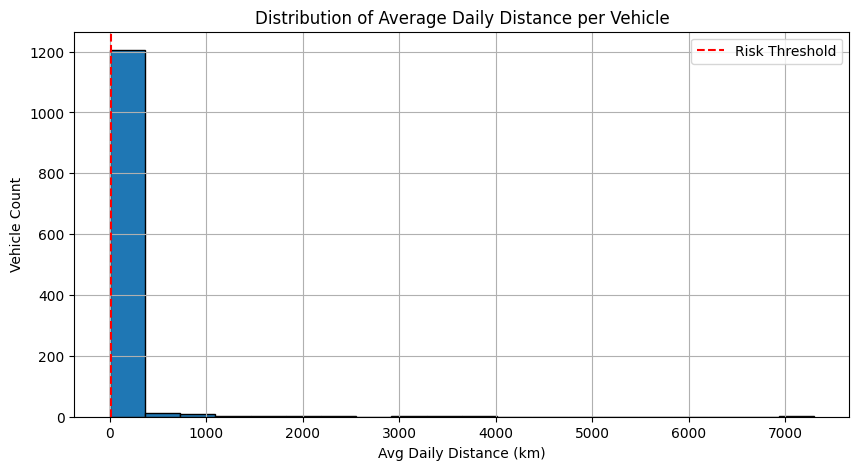

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(daily_avg['avg_daily_km'], bins=20, edgecolor='k')
plt.axvline(risk_threshold, color='red', linestyle='--', label='Risk Threshold')
plt.title("Distribution of Average Daily Distance per Vehicle")
plt.xlabel("Avg Daily Distance (km)")
plt.ylabel("Vehicle Count")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
daily_avg[daily_avg['likely_default_percentile']].drop_duplicates(subset='vin')

vin  avg_daily_km  likely_default  \
16    MD9EMHDL22E217034      0.000000            True   
17    MD9EMHDL22E217035      0.143996            True   
18    MD9EMHDL22E217036      4.938121            True   
21    MD9EMHDL22E217060      0.000000            True   
22    MD9EMHDL22E217062      0.000000            True   
...                 ...           ...             ...   
1148  MD9EMHDL24H217208      0.000000            True   
1159  MD9EMHDL24J217026      4.819708            True   
1166  MD9EMHDL24J217041      4.683088            True   
1205  MD9EMHDL24J217234      0.000000            True   
1235  MD9EMHDL24K217269      0.113362            True   

      likely_default_percentile  
16                         True  
17                         True  
18                         True  
21                         True  
22                         True  
...                         ...  
1148                       True  
1159                       True  
1166                       True  
1205                       True  
1235                       True  

[248 rows x 4 columns]

In [18]:
default_vehicles = daily_avg[daily_avg['likely_default'] == True]

# Save to Excel
default_vehicles.to_excel("Q3_Default_Vehicles.xlsx", index=False)
